<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/2_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Model

We now have four folders of topoplot images (which you should zip into *img_data.zip*) that will be used to train our model. We will utilise the fast.ai library - a deep learning library built ontop of PyTorch that provides high level abstractions for model training.

In [1]:
import os
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
!unzip -q /content/img_data.zip
!rm /content/img_data.zip

As our model's purpose is to classify blinks, we should split our data into positive and negative examples. However, we should ensure each cateogry is roughly the same size. We will use the entirety of the img_blinks dataset, and sample from img_rest, h_saccades, and v_saccades using a 50/25/25 split.

In [5]:
def count_files(path):
    count = 0
    for img in os.listdir(path):
        count += 1
    return count

n_blinks = count_files('/content/img_data/img_blinks')
n_v_saccades = count_files('/content/img_data/img_v_saccades')
n_h_saccades = count_files('/content/img_data/img_h_saccades')
n_rest = count_files('/content/img_data/img_rest')

print(f'Number of blinks: {n_blinks}')
print(f'Number of vertical saccades: {n_v_saccades}')
print(f'Number of horizontal saccades: {n_h_saccades}')
print(f'Number of rest: {n_rest}')

Number of blinks: 4562
Number of vertical saccades: 1140
Number of horizontal saccades: 1140
Number of rest: 2281


After deleting excess files the positive and negative datasets are now equal. You can verify by running count_files() once more.

In [4]:
def delete_excess_files(path, idx):
    for img in os.listdir(path)[idx:]:
        os.remove(os.path.join(path, img))

delete_excess_files('/content/img_data/img_v_saccades', n_blinks//4)
delete_excess_files('/content/img_data/img_h_saccades', n_blinks//4)
delete_excess_files('/content/img_data/img_rest', n_blinks//2)

Reorganise directories so that DataLoaders works and labels are correct etc etc....

In [6]:
# Rename so that classification labels are correct
os.rename('/content/img_data/img_blinks', '/content/img_data/blink')
os.mkdir('/content/img_data/non-blink')

# Move all three to non-blink folder
for img in os.listdir('/content/img_data/img_rest'):
    os.rename(os.path.join('/content/img_data/img_rest', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_v_saccades'):
    os.rename(os.path.join('/content/img_data/img_v_saccades', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_h_saccades'):
    os.rename(os.path.join('/content/img_data/img_h_saccades', img), os.path.join('/content/img_data/non-blink', img))

In [7]:
!rm -r '/content/img_data/img_rest'
!rm -r '/content/img_data/img_v_saccades'
!rm -r '/content/img_data/img_h_saccades'

# DataLoaders and Model Training

...

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=91),
    get_y=parent_label,
    item_tfms=Resize(224) # This needs to be set to crop the images!
)

In [9]:
dls = dblock.dataloaders('/content/img_data')

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.669913,0.423011,0.188048,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.451578,0.372598,0.158991,00:38
1,0.396057,0.334622,0.153509,00:34
2,0.309244,0.332352,0.146930,00:38
3,0.246792,0.325679,0.150219,00:36


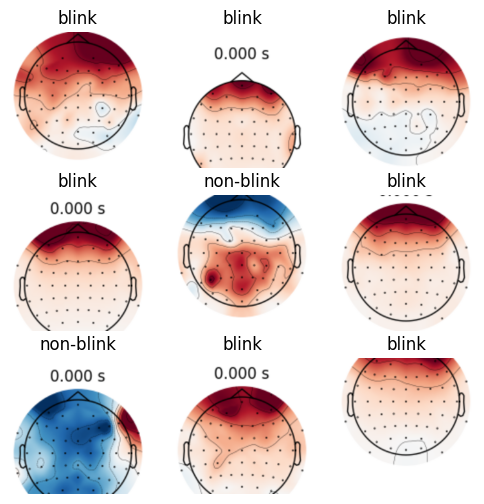

In [11]:
dls.show_batch(max_n=9, figsize=(6,6))

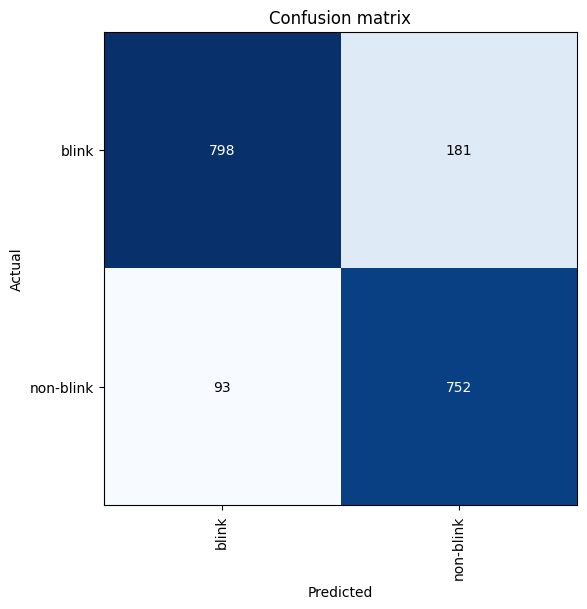

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

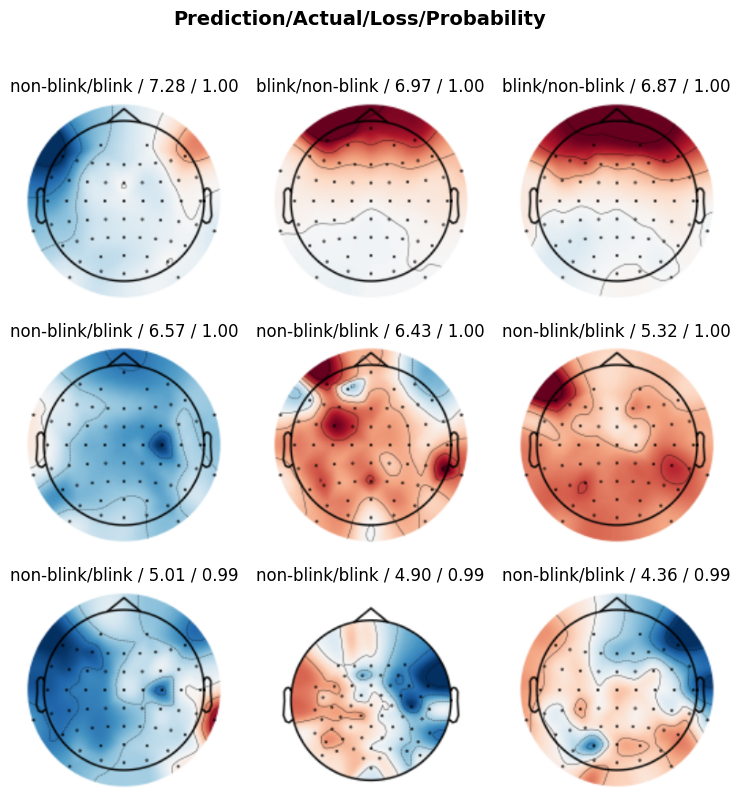

In [13]:
interp.plot_top_losses(k=9, figsize=(9,9))

Note: eye-movements may be too similar to blinks, may have to remove for now. Try blink / rest only.